In [68]:
##Facility location problem
##Modeled in JuMP, Solver = Gurobi

println("-------------------------------------------");
println("READING MODEL");

using JuMP
using Cbc
using PyPlot

## Import Data
customer_matrix = readcsv("Customer.csv");           # Customers information
source_matrix = readcsv("Source.csv");               # Potential sources information
facility_matrix = readcsv("Facilities.csv");         # Data about facilities
demand_matrix = readcsv("Demand.csv");               # Demands in 3 scenarios
probability_matrix = readcsv("Probability.csv");     # Probability of 3 scenarios

## Define Sets
customer = customer_matrix[:,1];                     # Set of custormer nodes
source = source_matrix[:,1];                         # Set of source nodes
facility = facility_matrix[:,1];                     # Set of facilities we can intall
scenario = 1:length(probability_matrix[:,1]);        # Set of scenarios

## Define Normal Dictionaries 
Xc = Dict(zip(customer, customer_matrix[:,2]));      # Match each customer with its location(x,y)[=](km,km)
Yc = Dict(zip(customer, customer_matrix[:,3]));
Xs = Dict(zip(source, source_matrix[:,2]));          # Match each source node with its location(x,y)[=](km,km)
Ys = Dict(zip(source, source_matrix[:,3]));
Cap= Dict(zip(facility, facility_matrix[:,2]));      # Match each facility with its maximum production capacity(tonne/year)
Inv= Dict(zip(facility, facility_matrix[:,3]));      # Match each facility with its investment cost($)
Op = Dict(zip(facility, facility_matrix[:,4]));      # Match each facility with its operational cost($/year)
Pr = Dict(zip(scenario, probability_matrix[:,1]));   # Match each scenario with its probability

## Define Two-key Dictionaries
distance = Dict(("A", "I") => 60.21);                # Distances beween source and customer, the first line is an initiator
for i in source
    for j in customer
       distance[(i, j)] = sqrt((Xs[i]-Xc[j])^2 + (Ys[i]-Yc[j])^2);
    end
end

demand = Dict(("I",1) => 100.5);                     # Demands of customers in each scenario
for j in 1:length(customer)
    for s in scenario
        demand[(customer[j],s)] = demand_matrix[j,s];
    end
end

## Establish Model

m = Model(solver = CbcSolver());

@variable(m, y[source,facility], Bin);               # Binary variables: technology t is installed in source i <=> y[i,t] = 1
@variable(m, f[source,customer,scenario]>=0);        # Flow of product from source i to customer j in scenario s
@variable(m, z[customer,scenario]>=0);               # Unsatisfied demand of customer j in scenario s

# At most one facility can be placed at one source
@constraint(m, onetech[i in source], sum(y[i,t] for t in facility) <=1);

# Balance constraint in each customer node
@constraint(m, balance[j in customer, s in scenario], sum(f[i,j,s] for i in source) + z[j,s] >= demand[j,s]);

# Capacity constraint in each source node
@constraint(m, capacity[i in source, s in scenario], sum(f[i,j,s] for j in customer) <= sum(y[i,t]*Cap[t] for t in facility));

# Define some intermediate quantities
@variable(m, investment>=0);                         # Total annual investment cost
@variable(m, operation>=0);                          # Total operational cost
@variable(m, transcost>=0);                          # Expected total transportation cost (summed and weighted by the probability)
@variable(m, penalty>=0);                            # Expected total penalty caused by unsatisfied demand

# Calculate total investement cost (annualized by life = 20 year)
@constraint(m, investment == sum(y[i,t]*Inv[t]/20 for i in source for t in facility));

# Calculate total operational cost
@constraint(m, operation == sum(y[i,t]*Op[t] for i in source for t in facility));
                     
# Calculate expected total transportation cost with transportation cost = $0.3/tonne/km                              
@constraint(m, transcost == sum(f[i,j,s]*distance[i,j]*0.3*Pr[s] for i in source for j in customer for s in scenario));     

# Calculate expected total penalty with $40 per unit of unsatisfied demand                                                  
@constraint(m, penalty == sum(Pr[s]*40*z[j,s] for j in customer for s in scenario));   
    
# Objective function is to minimize total annual expense                                                                    
@objective(m, Min, investment + operation + transcost + penalty); 
                                                                    
## Solve the model and output results
println("-------------------------------------------");
println("SOLVER BEGINS");
println("-------------------------------------------");
solve(m);
println("-------------------------------------------");
println("SOLVER ENDS");
println("-------------------------------------------\n"); 
println("Facility Installation Result:\n");
for i in source
for t in facility
    if getvalue(y[i, t]) >= 0.5
      println("	",t," is installed at ", i, "(",Xs[i],",",Ys[i],")");
    end
end
end
println("\n");
println("Expected Total Annual Cost(\$):\n	", getobjectivevalue(m));
println("Transport Cost(\$):\n	", getvalue(transcost));
println("Penalty Cost(\$):\n	", getvalue(penalty));              
                                                                                                                
for s in scenario                                                                                                     
for i in source
for j in customer
    if getvalue(f[i, j, s]) > 0
      println("	", "Flow between source ", i," and consumer ", j, " in scenario ", s, " is: ", getvalue(f[i, j, s]));
    end
end
end  
end

-------------------------------------------
READING MODEL
-------------------------------------------
SOLVER BEGINS
-------------------------------------------
-------------------------------------------
SOLVER ENDS
-------------------------------------------

Facility Installation Result:

	t3 is installed at C(45,35)
	t3 is installed at D(60,95)
	t3 is installed at E(100,30)


Expected Total Annual Cost($):
	19575.967013596528
Transport Cost($):
	8957.967013596528
Penalty Cost($):
	1167.9999999999973
	Flow between source C and consumer I in scenario 1 is: 119.99999999999999
	Flow between source C and consumer II in scenario 1 is: 39.99999999999994
	Flow between source C and consumer III in scenario 1 is: 140.00000000000009
	Flow between source D and consumer II in scenario 1 is: 25.000000000000053
	Flow between source D and consumer IV in scenario 1 is: 274.99999999999994
	Flow between source E and consumer III in scenario 1 is: 300.0
	Flow between source C and consumer I in scenario

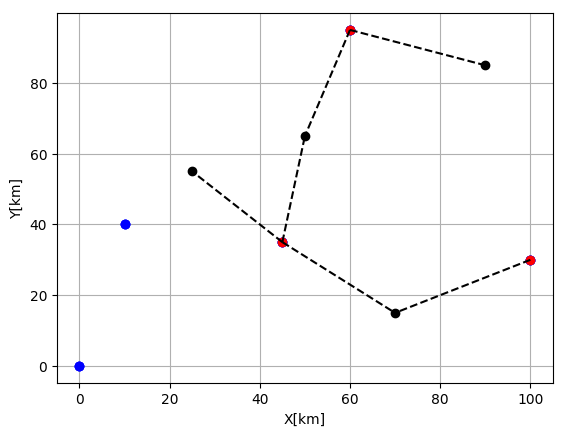

In [69]:
# visualize solution first scenario
for i in source
for t in facility
    plot([Xs[i]],[Ys[i]],"bo")
    if getvalue(y[i, t]) >= 0.5
      plot([Xs[i]],[Ys[i]],"ro")
    end
end
end
grid("on")
for j in customer
      plot([Xc[j]],[Yc[j]],"ko",label=j)
end
for s in 1:1
for i in source
for j in customer
    if getvalue(f[i, j, s]) > 0
      plot([Xs[i],Xc[j]],[Ys[i],Yc[j]],"k--")
    end
end
end  
end
xlabel("X[km]")
ylabel("Y[km]");

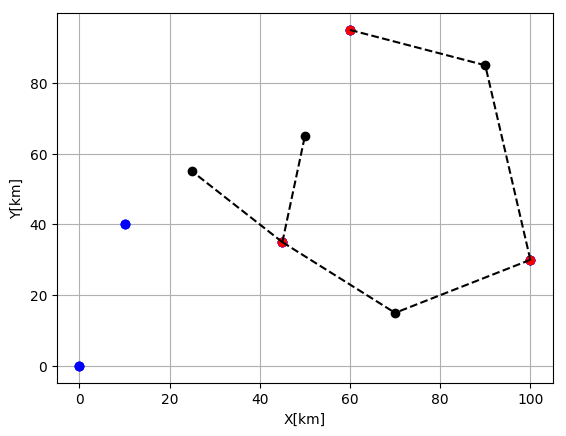

In [70]:
# visualize solution second scenario
for i in source
for t in facility
    plot([Xs[i]],[Ys[i]],"bo")
    if getvalue(y[i, t]) >= 0.5
      plot([Xs[i]],[Ys[i]],"ro")
    end
end
end
grid("on")
for j in customer
      plot([Xc[j]],[Yc[j]],"ko")
end
for s in 2:2
for i in source
for j in customer
    if getvalue(f[i, j, s]) > 0
      plot([Xs[i],Xc[j]],[Ys[i],Yc[j]],"k--")
    end
end
end  
end
xlabel("X[km]")
ylabel("Y[km]");

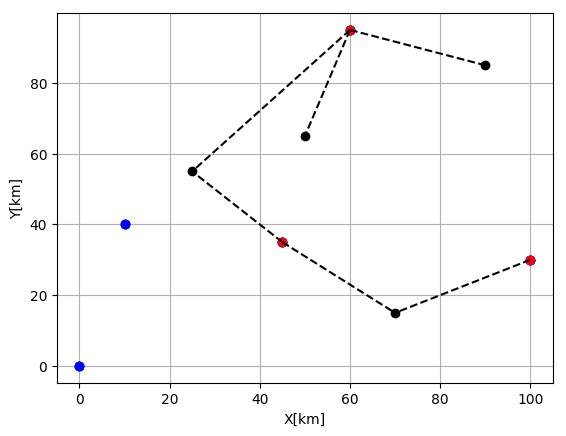

In [71]:
# visualize solution third scenario
for i in source
for t in facility
    plot([Xs[i]],[Ys[i]],"bo")
    if getvalue(y[i, t]) >= 0.5
      plot([Xs[i]],[Ys[i]],"ro")
    end
end
end
grid("on")
for j in customer
      plot([Xc[j]],[Yc[j]],"ko")
end
for s in 3:3
for i in source
for j in customer
    if getvalue(f[i, j, s]) > 0
      plot([Xs[i],Xc[j]],[Ys[i],Yc[j]],"k--")
    end
end
end  
end
xlabel("X[km]")
ylabel("Y[km]");